In [1]:
import scipy.io
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

from joblib import Parallel, delayed
import time
from itertools import product
import pandas as pd

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

In [2]:
def make_XOR(n_samples=100, cluster_center=[0,0], cluster_std=0.25, dist_from_center=0.5,
             N_XOR=False, theta_rotation=0, random_state=None):
    
    #variable setup
    seed = random_state
    dist = dist_from_center
    std = cluster_std
    n = int(n_samples/4)
    
    cluster_centers = np.array(list(product([dist, -dist], repeat=2)))
    cluster_centers = cluster_center - cluster_centers
    n_per_cluster = np.full(shape=2, fill_value=n)

    #make blobs
    X1,_ = datasets.make_blobs(n_samples=n_per_cluster, n_features=2, centers=cluster_centers[[0,3], :], 
                               cluster_std=std, random_state=seed)
    X2,_ = datasets.make_blobs(n_samples=n_per_cluster, n_features=2, centers=cluster_centers[[1,2], :], 
                               cluster_std=std, random_state=seed)
    
    #assign classe
    if N_XOR:
        y1, y2 = -np.ones(n*2), np.ones(n*2)
    else:
        y1, y2 = np.ones(n*2), -np.ones(n*2)

    X = np.concatenate((X1, X2))
    y = np.concatenate((y1, y2))

    #rotation
    c, s = np.cos(theta_rotation), np.sin(theta_rotation)
    R = np.array([[c, -s], [s, c]])
    X = (R @ X.T).T
    
    return X,y

In [3]:
def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

In [4]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m-1,:] *= -1
        R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

In [5]:
def icp(A, B, init_pose=None, max_iterations=200, tolerance=1e-26):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, src, i

In [30]:
# Supervised point set registration
x1, y1 = make_XOR(n_samples=1000)
x2, y2 = make_XOR(n_samples=1000, theta_rotation=np.pi/2)

#Grid Setup for XOR1
h = 0.05 
X1 = x1.copy()
Y1 = y1.copy()
x1_min, x1_max = X1[:,0].min()-1, X1[:,0].max()+1 
y1_min, y1_max = X1[:,1].min()-1, X1[:,1].max()+1 
xx1, yy1 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(y1_min, y1_max, h))
grid1 = np.c_[xx1.ravel(), yy1.ravel()]

#Grid Setup for XOR2
h = 0.05 
X2 = x2.copy()
Y2 = y2.copy()
x2_min, x2_max = X2[:,0].min()-1, X2[:,0].max()+1 
y2_min, y2_max = X2[:,1].min()-1, X2[:,1].max()+1 
xx2, yy2 = np.meshgrid(np.arange(x2_min, x2_max, h), np.arange(y2_min, y2_max, h))
grid2 = np.c_[xx2.ravel(), yy2.ravel()]

#Grid Setup for XOR3
h = 0.05 
x1y1 = x1[np.where(y1 == 1)[0]]
x1y2 = x1[np.where(y1 == -1)[0]]
x2y1 = x2[np.where(y1 == 1)[0]]
x2y2 = x2[np.where(y1 == -1)[0]]

#T_1, X3_1, i = icp(x2y1.copy(), x1y1.copy())
#X3_1 = X3_1.T[:,0:2]
#T_2, X3_2, i = icp(x2y2.copy(), x1y2.copy())
#X3_2 = X3_2.T[:,0:2]

#X3 = np.concatenate((X3_1, X3_2), axis=0)

T_1, X3_1, i = icp(x2y1.copy(), x1y1.copy())
X3_1 = X3_1.T[:,0:2]
T_2, X3_2, i = icp(x2y2.copy(), x1y2.copy())
X3_2 = X3_2.T[:,0:2]
T_mean = (T_1+T_2) / 2
        
m = x2.shape[1]
src = np.ones((m+1,x2.shape[0]))
src[:m,:] = np.copy(x2.T)
src = np.dot(T_mean, src)
        
X3 = src.T[:,0:2]

Y3 = y2.copy()
x3_min, x3_max = X3[:,0].min()-1, X3[:,0].max()+1 
y3_min, y3_max = X3[:,1].min()-1, X3[:,1].max()+1 
xx3, yy3 = np.meshgrid(np.arange(x3_min, x3_max, h), np.arange(y3_min, y3_max, h))
grid3 = np.c_[xx3.ravel(), yy3.ravel()]

#Predicting for XOR1
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ1 = clf.fit(X1,Y1).predict_proba(grid1)[:,0]
ZZ1 = ZZ1.reshape(xx1.shape)

#Predicting for XOR2
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ2 = clf.fit(X2,Y2).predict_proba(grid2)[:,0]
ZZ2 = ZZ2.reshape(xx2.shape)

clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ3 = clf.fit(X3,Y3).predict_proba(grid3)[:,0]
ZZ3 = ZZ3.reshape(xx3.shape)

<ipython-input-31-9894992c5542>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, yy1, ZZ1);
<ipython-input-31-9894992c5542>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx2, yy2, ZZ2);
<ipython-input-31-9894992c5542>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 

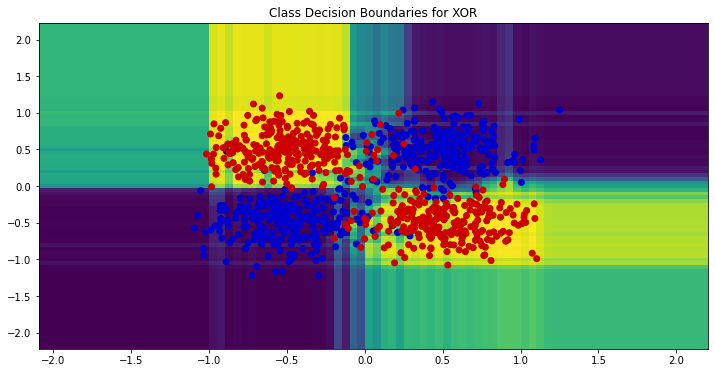

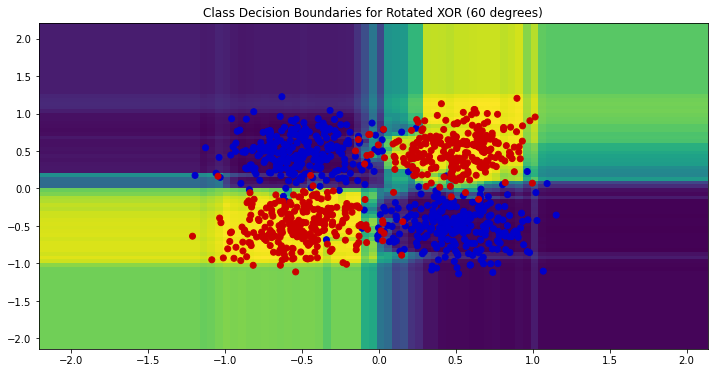

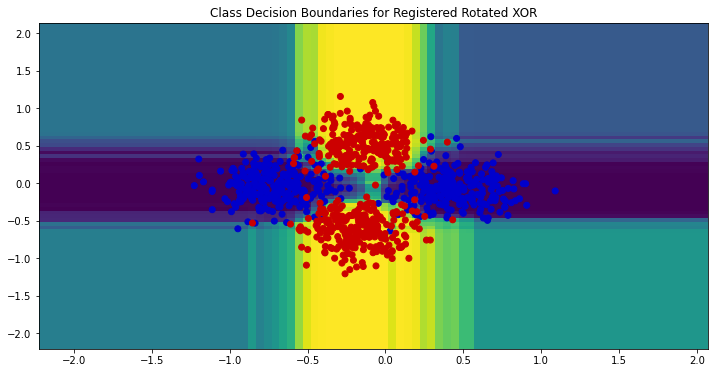

In [31]:
#Plot the decision boundary for XOR1
plt.figure(figsize=(12,6));
plt.pcolormesh(xx1, yy1, ZZ1);
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=cmap_bold);
plt.xlim(xx1.min(), xx1.max());
plt.ylim(yy1.min(), yy1.max());
plt.title('Class Decision Boundaries for XOR');

#Plot the decision boundary for XOR2
plt.figure(figsize=(12,6));
plt.pcolormesh(xx2, yy2, ZZ2);
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=cmap_bold);
plt.xlim(xx2.min(), xx2.max());
plt.ylim(yy2.min(), yy2.max());
plt.title('Class Decision Boundaries for Rotated XOR (60 degrees)');

#Plot the decision boundary for XOR3
plt.figure(figsize=(12,6));
plt.pcolormesh(xx3, yy3, ZZ3);
plt.scatter(X3[:,0], X3[:,1], c=y2, cmap=cmap_bold);
plt.xlim(xx3.min(), xx3.max());
plt.ylim(yy3.min(), yy3.max());
plt.title('Class Decision Boundaries for Registered Rotated XOR');

In [10]:
def LF_experiment(x1, y1, x2, y2, ntrees, acorn=None):
  
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : 30}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                         default_transformer_kwargs = default_transformer_kwargs,
                                         default_voter_class = default_voter_class,
                                         default_voter_kwargs = default_voter_kwargs,
                                         default_decider_class = default_decider_class)

    #errors = np.zeros(2)
    
    if acorn is not None:
        np.random.seed(acorn)

    progressive_learner.add_task(
        X = x1,
        y = y1,
        decider_kwargs = {"classes" : np.unique(y1)},
        voter_kwargs = {"classes" : np.unique(y1)}
    )

    #progressive_learner.add_transformer(
        #X = x2,
        #y = y2,
        #decider_kwargs = {"classes" : np.unique(train_y2)},
        #voter_kwargs = {"classes" : np.unique(train_y2)},
        #backward_task_ids = [0]
    #)

    llf_single_task=progressive_learner.predict(x2, task_id=0, transformer_ids=[0])
    #llf_task1=progressive_learner.predict(test_x, task_id=0)
    
    errors = (1 - np.mean(llf_single_task == y2))
    #errors[1] = errors[1]+(1 - np.mean(llf_task1 == test_y))

    #print("Errors: {}".format(errors))
    return errors

In [23]:
def run_parallel_exp(n_trees, angle, register):
    x1, y1 = make_XOR(n_samples=1000)
    x2, y2 = make_XOR(n_samples=1000, theta_rotation=angle)
    #plt.scatter(x2[:,0], x2[:,1])
    
    if register:
        x1y1 = x1[np.where(y1 == 1)[0]]
        x1y2 = x1[np.where(y1 == -1)[0]]
        x2y1 = x2[np.where(y1 == 1)[0]]
        x2y2 = x2[np.where(y1 == -1)[0]]

        T_1, X3_1, i = icp(x2y1.copy(), x1y1.copy())
        X3_1 = X3_1.T[:,0:2]
        T_2, X3_2, i = icp(x2y2.copy(), x1y2.copy())
        X3_2 = X3_2.T[:,0:2]
        T_mean = (T_1+T_2) / 2
        
        m = x2.shape[1]
        src = np.ones((m+1,x2.shape[0]))
        src[:m,:] = np.copy(x2.T)
        src = np.dot(T_mean, src)
        
        x2 = src.T[:,0:2]
        #plt.figure()
        #plt.scatter(x2[:,0], x2[:,1])
    
    errors = LF_experiment(x1, y1, x2, y2, n_trees, acorn=12345)
    
    return errors

In [24]:
reps = range(20)
n_trees=20 # Number of trees in UF
errors_noreg = np.zeros(20)
errors_reg = np.zeros(20)

angles = [np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, 5*np.pi/6, np.pi]
#angles = [np.pi/4]
mean_errors_noreg = []
mean_errors_reg = []

for angle in angles:

    for i in reps:
        errors_noreg[i] = run_parallel_exp(n_trees, angle, register=False)
        errors_reg[i] = run_parallel_exp(n_trees, angle, register=True)
        
    mean_errors_noreg.append(np.mean(errors_noreg))
    mean_errors_reg.append(np.mean(errors_reg))

Text(0, 0.5, 'Mean Generalization error (20 trials)')

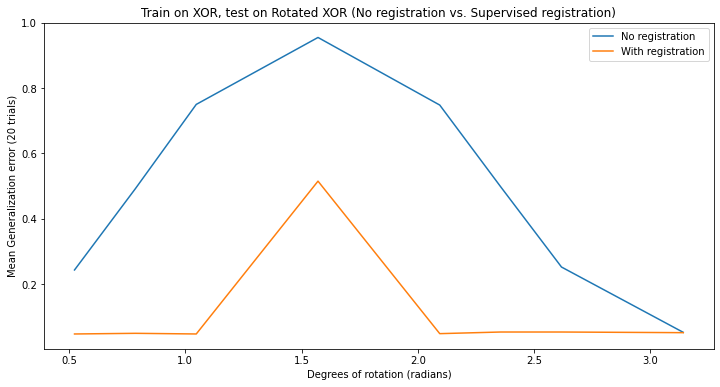

In [25]:
plt.figure(figsize=(12,6));
plt.plot(angles, mean_errors_noreg)
plt.plot(angles, mean_errors_reg)
plt.title("Train on XOR, test on Rotated XOR (No registration vs. Supervised registration)")
plt.legend(['No registration', 'With registration'])
plt.xlabel('Degrees of rotation (radians)')
plt.ylabel('Mean Generalization error (20 trials)')